In [1]:
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./test_pred.csv
./Untitled.ipynb
./test_pred(최고).csv
./CNN.ipynb
./test.csv
./Transformer(최종).ipynb
./train.csv
./Transformer.ipynb
./model_resent_norm_early2.pkl
./test_pred_resent10_early.csv
./ResNet_norm5_early.ipynb
./Transformer2.ipynb
./test_pred2.csv
./.ipynb_checkpoints/Transformer(최종)-checkpoint.ipynb
./.ipynb_checkpoints/CNN-checkpoint.ipynb
./.ipynb_checkpoints/ResNet_norm5_early-checkpoint.ipynb
./.ipynb_checkpoints/Transformer-checkpoint.ipynb
./.ipynb_checkpoints/Transformer2-checkpoint.ipynb
./.ipynb_checkpoints/Untitled-checkpoint.ipynb


# gray scale 인 것을 유념!!
- 기본 train 데이터로 학습 시키고
- 그 모델을 가지고 validation data 까지 전체 train data로 사용

In [2]:
# ============================== Do not edit this shell ==========================================

# Dataset Definition

import csv
import numpy as np
import pandas as pd
import torch

from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

class CharDataset(Dataset):
    def __init__(self, root, train, transform=None):
        self.train = train
        if self.train:
            root = root + 'train.csv'
        else:
            root = root + 'test.csv'
        self.csv = pd.read_csv(root, header=None)
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        if self.train:
            label = torch.tensor(self.csv.iloc[index,0], dtype=torch.long)
            img = np.array(self.csv.iloc[index,1:]/255).reshape(28, 28)
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img, label
        else:
            img = np.array(self.csv.loc[index]/255).reshape(28, 28)
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img
        
# ============================== Do not edit this shell ==========================================

GPU will be used in training/validation.
===================== Check the data =========================

Train dataset length = 13481
Valid dataset length = 1498
Test dataset length = 3745

Content of Y (Label, type=<class 'torch.Tensor'>) = 4
Shape of X (Data, type=<class 'torch.Tensor'>) = torch.Size([1, 224, 224])


/home/piai/anaconda3/envs/AIBD/lib/python3.8/site-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378062065/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


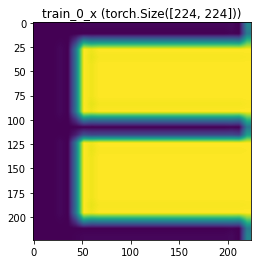

================== Check the data loader ======================

Idx: 0 / X.shape = torch.Size([16, 1, 224, 224]) / Y.shape = torch.Size([16])

Y[0:16] = tensor([0, 9, 2, 6, 3, 6, 8, 9, 5, 0, 9, 2, 7, 0, 7, 6])


In [3]:
# Library Importation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import gc


from PIL import Image
from IPython.display import clear_output
from multiprocessing import cpu_count
from torch.cuda import memory_allocated, empty_cache
from torch.optim import Adam

from sklearn.metrics import confusion_matrix
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary as Summary
import torchvision.transforms as transforms


from torchvision.datasets import MNIST
from torchvision import models
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, \
                                   ToPILImage, Resize, Grayscale


# Hyper Parameter
## Data Loader
batch_size = 16

## Model
hidden_layer = 300

# Learning
logging_dispfig = True
maximum_epoch = 200
ealystop_patience = 40
learning_rate = 1e-4


# Device Preparation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')

# Load dataset into python variable
input_transform = transforms.Compose([
  Resize(224),
  ToTensor(),
  Normalize(mean=(0.5,), std=(0.5,))
    
  ])

# Prepare dataset
root = './'
train_data = CharDataset(root, train=True, transform=input_transform)
train_data, valid_data = random_split(train_data, [round(len(train_data)*0.9), round(len(train_data)*0.1)])
test_data = CharDataset(root, train=False, transform=input_transform)

# Check the data
print('===================== Check the data =========================\n')
print(f'Train dataset length = {len(train_data)}')
print(f'Valid dataset length = {len(valid_data)}')
print(f'Test dataset length = {len(test_data)}\n')

train_0_x, train_0_y = train_data[0]
print(f'Content of Y (Label, type={type(train_0_y)}) = {train_0_y}')
print(f'Shape of X (Data, type={type(train_0_x)}) = {train_0_x.shape}')
plt.figure(1)
plt.imshow(train_0_x.squeeze())
plt.title(f'train_0_x ({train_0_x.squeeze().shape})')
plt.show()



# In order to see the power of transfer learning, let the size of data by 1/10

def minimize(num):
    mini = []
    for data in train_data:
        mini.append(data)
        num -= 1
        if num == 0: break
    return mini        
    
#train_data_mini = minimize(4500)
#valid_data_mini = minimize(500)
#test_data_mini = minimize(1000)

#train_0_x, train_0_y = train_data_mini[0]

# Create data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, pin_memory=True)


# Examine the data loader
print('================== Check the data loader ======================\n')
train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape}\n')
print(f'Y[0:{batch_size}] = {ex_label}')
preview_index = 0

In [4]:
# Model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def init_model(model_name, num_classes, feature_extract, use_pretrained=True):
    global net, loss_fn, optim, best_net
    
    # get CNN model from PyTorch Model Zoo
    if model_name == "resnet":
        """ Resnet18
        """
        net = models.resnet18(pretrained=use_pretrained)
        net.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=3,bias=False)
        set_parameter_requires_grad(net, feature_extract)
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    else:
        print("Choose Model between [resnet, alexnet, vgg, squeezenet, densenet, inception]")
        return 
    
    net = net.to(device)
    best_net = net.to(device)
    net = nn.DataParallel(net)
    best_net = nn.DataParallel(best_net)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)
    return input_size

In [5]:
# Memory cleaner to prevent CUDA out of memory error
def clear_memory():
    if device != 'cpu':
        empty_cache()
    garb_collected = gc.collect()

In [6]:
# Epoch
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0


def epoch(data_loader):
    # One epoch : gets data_loader as input and returns loss / accuracy, and
    #             last prediction value / its label(truth) value for future use
    global epoch_cnt
    iter_loss, iter_acc = [], []

    last_grad_performed = False

    # Mini-batch iterations
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.to(device)

        # 1. Feed-forward
        onehot_out = net(data)

        # 2. Calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

        # 3. Calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. Backward propagation if not in `torch.no_grad()`
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

    # Up epoch count if backward propagation is done
    if last_grad_performed:
        epoch_cnt += 1

    # Clear memory to prevent CUDA memory error
    clear_memory()
    
    return np.average(iter_loss), np.average(iter_acc)


def epoch_not_finished():
    # For now, let's repeat training fixed times, e.g. 25 times.
    # We will learn how to determine training stop or continue later.
    return epoch_cnt < ealystop_patience

In [7]:
# Logging
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []


def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)


def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)


def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1


def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
    log_stack.append(log_str)

    # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')

        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')

        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()

    # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

In [8]:
# Earlystopping Weight 카피
def copy_weights(src, dst):
    dst.load_state_dict(src.state_dict())

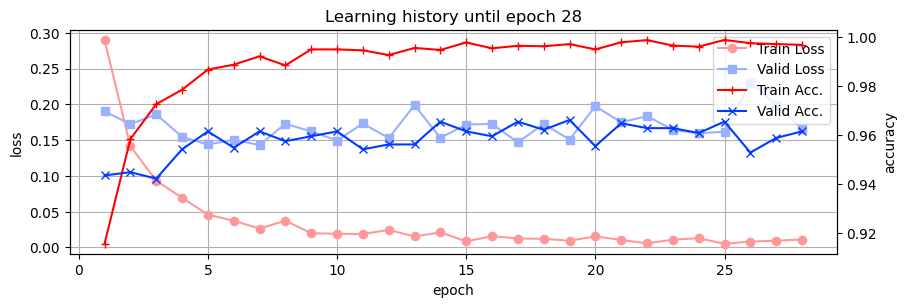

Iter:   28 >> T_loss 0.01097    T_acc 0.99673   V_loss 0.16579    V_acc 0.96144   🕒 1166.978s
Iter:   27 >> T_loss 0.00932    T_acc 0.99703   V_loss 0.19916    V_acc 0.95878   🕒 1166.350s
Iter:   26 >> T_loss 0.00807    T_acc 0.99740   V_loss 0.23042    V_acc 0.95279   🕒 1165.789s
Iter:   25 >> T_loss 0.00501    T_acc 0.99874   V_loss 0.16167    V_acc 0.96543   🕒 1167.194s
Iter:   24 >> T_loss 0.01281    T_acc 0.99599   V_loss 0.15945    V_acc 0.96077   🕒 1166.181s
Iter:   23 >> T_loss 0.01078    T_acc 0.99644   V_loss 0.16446    V_acc 0.96277   🕒 1167.208s
Iter:   22 >> T_loss 0.00561    T_acc 0.99866   V_loss 0.18338    V_acc 0.96277   🕒 1164.619s
Iter:   21 >> T_loss 0.01036    T_acc 0.99777   V_loss 0.17484    V_acc 0.96476   🕒 1164.287s
Iter:   20 >> T_loss 0.01533    T_acc 0.99488   V_loss 0.19724    V_acc 0.95545   🕒 1164.849s
Iter:   19 >> T_loss 0.00932    T_acc 0.99703   V_loss 0.15073    V_acc 0.96609   🕒 1165.448s
Iter:   18 >> T_loss 0.01199    T_acc 0.99614   V_loss 0.172

In [ ]:
# Training Initialization
init_model(model_name='resnet', num_classes=10, feature_extract=False, use_pretrained=True)
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(valid_loader)
        if len(vloss_log) and np.min(vloss_log)< vloss:
            ealystop_cnt += 1
        else : 
            ealystop_cnt = 0
            copy_weights(net, best_net)
        record_valid_log(vloss, vacc)
    print_log()

copy_weights(best_net, net)
  
print('\n Training completed\n')
for idx in reversed(range(len(log_stack))):
    print(log_stack[idx])

In [ ]:
# # Save prediction vector to CSV file

# # Before run this code, here put your save path
# save_root = './test_pred2.csv'   # <--- only edit this path

# # After run this code, you must check that the shape of 'out' variable is 3745. (out.shape == 3745)


# # ============================== Do not edit under this line ==========================================
# for _data in test_loader:
#     #data = _data.view([len(_data), -1]).to(device)
#     data = _data.to(device)

#     # 1. Feed-forward
#     onehot_out = net(data)
#     _,out = torch.max(onehot_out, 1)
    
# print(out.shape)

# import csv

# if os.path.isfile(save_root):
#     os.remove(save_root)

# for idx, pred in enumerate(list(out.cpu())):
#     with open(save_root, 'a', newline='') as f:
#         writer = csv.writer(f)
#         if idx == 0:
#             writer.writerow(['id', 'label'])
#         pred = np.concatenate(([idx], [pred]))
#         writer.writerow(pred)
# # ============================== Do not edit over this line ===
#     with torch.no_grad():=======================================

In [ ]:
test_loader

In [ ]:
def prediciton(test_loader, model):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(test_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [ ]:
save_root = './test_pred_resent10_early.csv'  

# tensor prediction
test_pred = prediciton(test_loader, best_net)


import csv

if os.path.isfile(save_root):
    os.remove(save_root)

for idx, pred in enumerate(test_pred):
    with open(save_root, 'a', newline='') as f:
        writer = csv.writer(f)
        if idx == 0:
            writer.writerow(['id', 'label'])
        pred = np.concatenate(([idx], [pred]))
        writer.writerow(pred)

In [ ]:
# To save
torch.save(net.state_dict(), './model_resent_norm_early2.pkl')

In [ ]:
# To load
resnet = torch.load('./model_resent_norm_early2.pkl')